In [ ]:
%cd /content/drive/MyDrive/Scribble Cardiac segmentation

/content/drive/MyDrive/Scribble Cardiac segmentation


In [ ]:
%ls data/ACDC/ACDC_trainig_slices

ls: cannot access 'data/ACDC/ACDC_trainig_slices': No such file or directory


In [ ]:
import os
import random
import re

# Path to the folder containing the files
directory = 'data/ACDC/ACDC_training_slices'
# Regular expression pattern to extract indices
pattern = r'patient(\d+)_frame(\d+)_slice_(\d+)\.h5'

# Function to extract indices from file names
def extract_indices(file_names):
    indices = []
    for file_name in file_names:
        match = re.match(pattern, file_name)
        if match:
            patient_index = int(match.group(1))
            frame_index = int(match.group(2))
            slice_index = int(match.group(3))
            indices.append((patient_index, frame_index, slice_index))
        else:
            print(f"Invalid file name: {file_name}")
    return indices

# List files in the folder
file_names = os.listdir(directory)

# Extract indices from file names
indices = extract_indices(file_names)

# Shuffle indices for random partitioning
random.shuffle(indices)

# Calculate partition sizes
total_samples = len(indices)
train_size = int(0.8 * total_samples)
dev_size = test_size = (total_samples - train_size) // 2

# Split indices into train, dev, and test sets
train_indices = indices[:train_size]
dev_indices = indices[train_size:train_size + dev_size]
test_indices = indices[train_size + dev_size:]

# Write train patient numbers to file
with open('data/ACDC/train_patients.list', 'w') as file:
    for patient_number in train_indices:
        file.write(str(patient_number) + '\n')

# Write validation patient numbers to file
with open('data/ACDC/val_patients.list', 'w') as file:
    for patient_number in dev_indices:
        file.write(str(patient_number) + '\n')

# Write test patient numbers to file
with open('data/ACDC/test_patients.list', 'w') as file:
    for patient_number in test_indices:
        file.write(str(patient_number) + '\n')

In [ ]:
with open('data/ACDC/val_patients.list', 'r') as f1:
    sample_list = f1.readlines()
    sample_list = [item.replace("\n", "") for item in sample_list]

In [ ]:
test_indices_sets = []
with open("data/ACDC/val_patients.list", 'r') as file:
    for line in file:
        # Strip parentheses and split by commas
        indices = line.strip()[1:-1].split(',')
        # Convert strings to integers and store as a tuple
        indices = tuple(map(int, indices))
        test_indices_sets.append(indices)

In [ ]:
import re
import os

# Path to the folder containing the files
directory = 'data/ACDC/ACDC_training_slices/'
# Regular expression pattern to match file names
pattern = r'^patient_080.*\.h5$'

# List files in directory
file_names = os.listdir(directory)

# Print file names that match the pattern
for file_name in file_names:
    print(file_name)

In [ ]:
%ls

data/  datasets/  train_val_test_split.ipynb


In [ ]:
%%writefile datasets/ACDC_dataset.py
import os
import cv2
import torch
import random
import numpy as np
from glob import glob
from torch.utils.data import Dataset
import h5py
from scipy.ndimage.interpolation import zoom
from torchvision import transforms
import itertools
from scipy import ndimage
from torch.utils.data.sampler import Sampler
import matplotlib.pyplot as plt
from PIL import Image


class BaseDataSets(Dataset):
    def __init__(
        self,
        base_dir=None,
        split="train",
        num=None,
        transform=None,
        ops_weak=None,
        ops_strong=None,
    ):
        self._base_dir = base_dir  #default: data/ACDC/  0: background   1: RV (right ventricle)   2: Myo (myocardium)  3: LV (left ventricle)   4: UA (unannotated pixels)
        self.sample_list = []
        self.split = split
        self.transform = transform
        self.ops_weak = ops_weak
        self.ops_strong = ops_strong

        assert bool(ops_weak) == bool(
            ops_strong
        ), "For using CTAugment learned policies, provide both weak and strong batch augmentation policy"

        if self.split == "train":
            with open(self._base_dir + "/train_patients.list", "r") as f:
                for line in f:
                    # Strip parentheses and split by commas
                    indices = line.strip()[1:-1].split(',')
                    # Convert strings to integers and store as a tuple
                    indices = tuple(map(int, indices))
                    self.sample_list.append(indices)

        elif self.split == "val":
            with open(self._base_dir + "/val_patients.list", "r") as f:
                for line in f:
                    # Strip parentheses and split by commas
                    indices = line.strip()[1:-1].split(',')
                    # Convert strings to integers and store as a tuple
                    indices = tuple(map(int, indices))
                    self.sample_list.append(indices)

        elif self.split == "test":
            with open(self._base_dir + "/test_patients.list", "r") as f:
                for line in f:
                    # Strip parentheses and split by commas
                    indices = line.strip()[1:-1].split(',')
                    # Convert strings to integers and store as a tuple
                    indices = tuple(map(int, indices))
                    self.sample_list.append(indices)

        if num is not None and self.split == "train":
            self.sample_list = self.sample_list[:num]
        print("total {} samples".format(len(self.sample_list)))

    def __len__(self):
        return len(self.sample_list)

    def __getitem__(self, idx):
        case = self.sample_list[idx] # case is a tuple (index_patient, index_frame, index_slice)
        h5f = h5py.File(self._base_dir + "ACDC_training_slices/patient{:03d}_frame{:02d}_slice_{}.h5".format(case[0], case[1], case[2]), "r")
        image = h5f["image"][:]
        gt = h5f["label"][:]
        label = h5f['scribble'][:]
        sample = {"image": image, "gt": gt, 'label': label}
        if self.split == "train":
            if None not in (self.ops_weak, self.ops_strong):
                sample = self.transform(sample, self.ops_weak, self.ops_strong)
            elif self.transform is not None:
                sample = self.transform(sample)
            else:
                sample['image'] = torch.from_numpy(sample['image'].astype(np.float32))
                sample['gt'] = torch.from_numpy(sample['gt'].astype(np.uint8))
                sample['label'] = torch.from_numpy(sample['label'].astype(np.uint8))
        sample["idx"] = idx
        return sample


def random_rot_flip(image, label=None):
    k = np.random.randint(0, 4)
    image = np.rot90(image, k)
    axis = np.random.randint(0, 2)
    image = np.flip(image, axis=axis).copy()
    if label is not None:
        label = np.rot90(label, k)
        label = np.flip(label, axis=axis).copy()
        return image, label
    else:
        return image


def random_rotate(image, label):
    angle = np.random.randint(-20, 20)
    image = ndimage.rotate(image, angle, order=0, reshape=False)
    label = ndimage.rotate(label, angle, order=0, reshape=False)
    return image, label


def color_jitter(image):
    if not torch.is_tensor(image):
        np_to_tensor = transforms.ToTensor()
        image = np_to_tensor(image)

    # s is the strength of color distortion.
    s = 1.0
    jitter = transforms.ColorJitter(0.8 * s, 0.8 * s, 0.8 * s, 0.2 * s)
    return jitter(image)

class RandomGenerator(object):
    def __init__(self, output_size):
        self.output_size = output_size

    def __call__(self, sample):
        image, label, gt  = sample["image"], sample["label"]
        # ind = random.randrange(0, img.shape[0])
        # image = img[ind, ...]
        # label = lab[ind, ...]
        if random.random() > 0.5:
            image, label = random_rot_flip(image, label)
        elif random.random() < 0.5:
            image, label = random_rotate(image, label)
        x, y = image.shape
        image = zoom(image, (self.output_size[0] / x, self.output_size[1] / y), order=0)
        label = zoom(label, (self.output_size[0] / x, self.output_size[1] / y), order=0)
        #gt = zoom(gt, (self.output_size[0] / x, self.output_size[1] / y), order=0)
        image = torch.from_numpy(image.astype(np.float32)).unsqueeze(0)
        label = torch.from_numpy(label.astype(np.uint8))
        #gt = torch.from_numpy(gt.astype(np.uint8))
        #sample = {"image": image, "label": label, 'gt': gt}
        sample = {"image": image, "label": label}
        return sample


def iterate_once(iterable):
    return np.random.permutation(iterable)


def iterate_eternally(indices):
    def infinite_shuffles():
        while True:
            yield np.random.permutation(indices)

    return itertools.chain.from_iterable(infinite_shuffles())


def grouper(iterable, n):
    "Collect data into fixed-length chunks or blocks"
    # grouper('ABCDEFG', 3) --> ABC DEF"
    args = [iter(iterable)] * n
    return zip(*args)

Writing datasets/ACDC_dataset.py


In [ ]:
dataset_for_plot = BaseDataSets(
    base_dir="data/ACDC/",
    split="train",
    num=None,
    transform=None,
)

total 1521 samples


In [ ]:
dataset_for_plot[0]['label'].unique()

tensor([0, 1, 2, 3, 4], dtype=torch.uint8)

In [ ]:
%%writefile datasets/utils.py
def blend_image_label(image, label, alpha=0.5):
    return (1 - alpha) * image + alpha * label

def plot_all(sample):
    image = sample['image']
    gt = sample['gt']
    label = sample['label']
    blended_image_gt = blend_image_label(image, gt)
    blended_image_scribble = blend_image_label(image, label, 0.3)

    plt.figure(figsize=(15, 5))
    # Plot images
    plt.subplot(1, 4, 1)
    plt.imshow(gt, cmap='gray')
    plt.title('gt')
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.imshow(blended_image_gt, cmap='gray')
    plt.title('img_gt')
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.imshow(label, cmap='gray')
    plt.title('scribble')
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.imshow(blended_image_scribble, cmap='gray')
    plt.title('img_scribble')
    plt.axis('off')

    plt.show()

Writing datasets/utils.py


In [ ]:
def _one_hot_encoder(input_tensor):
    tensor_list = []
    for i in range(5):
        temp_prob = input_tensor == i  # * torch.ones_like(input_tensor)
        tensor_list.append(temp_prob.unsqueeze(0))
    output_tensor = torch.cat(tensor_list, dim=0)
    return output_tensor.float()

In [ ]:
aa = _one_hot_encoder(dataset_for_plot[0]['label'])

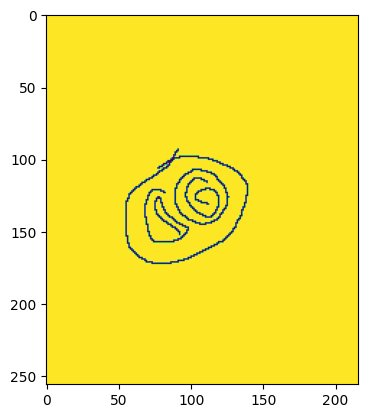

In [ ]:
plt.imshow(aa[4,:,:])

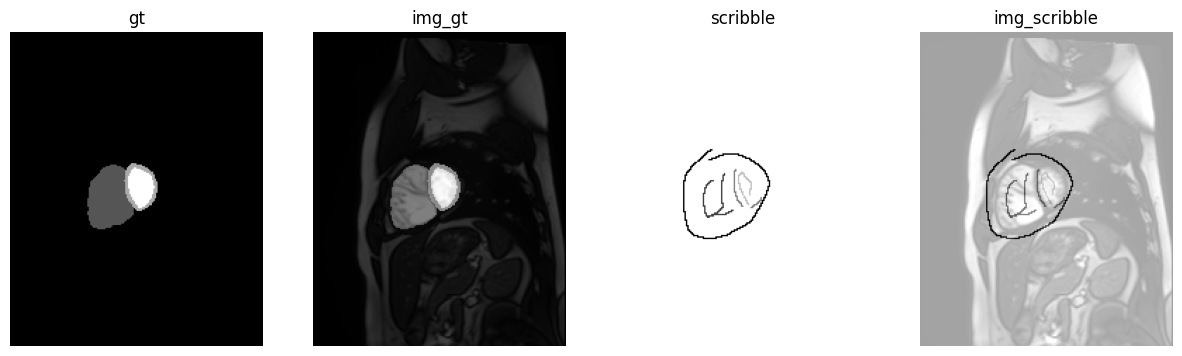

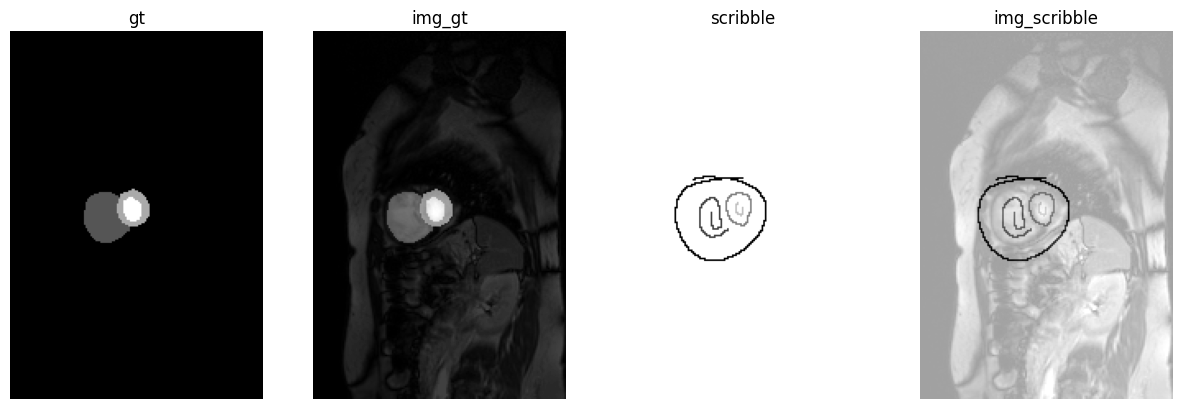

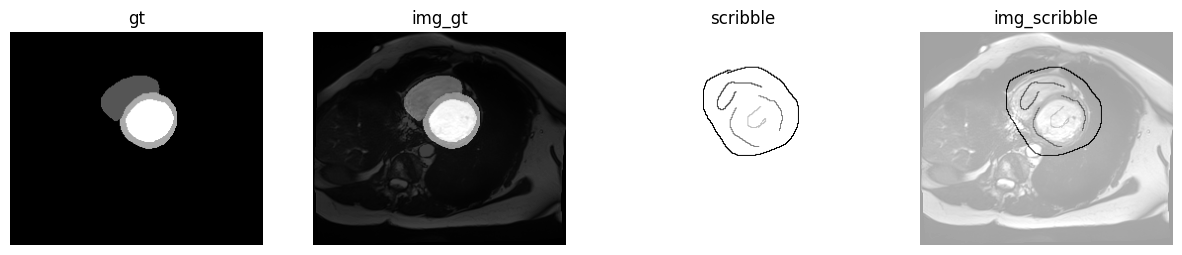

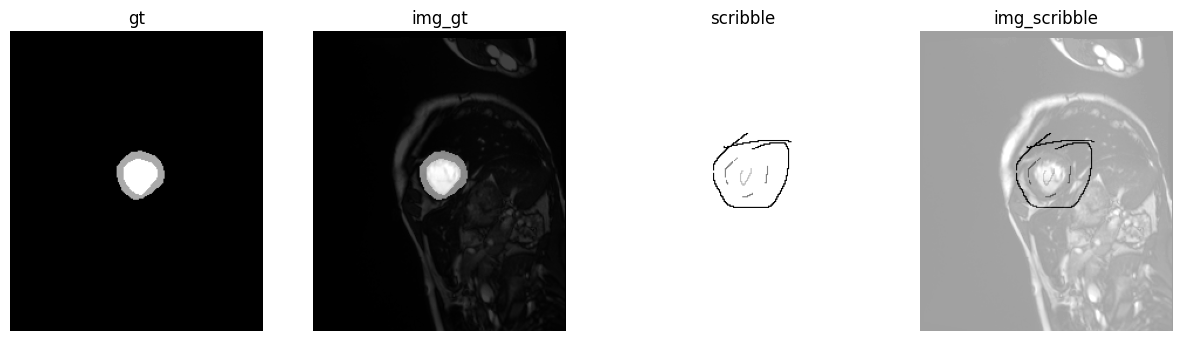

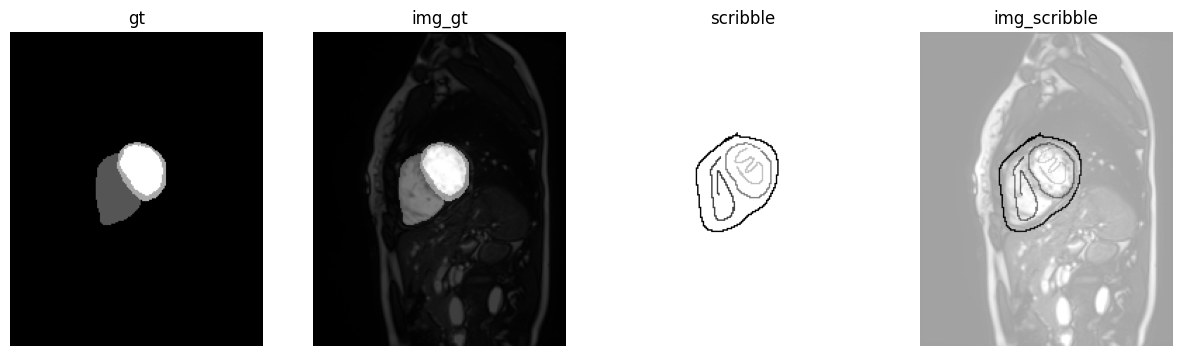

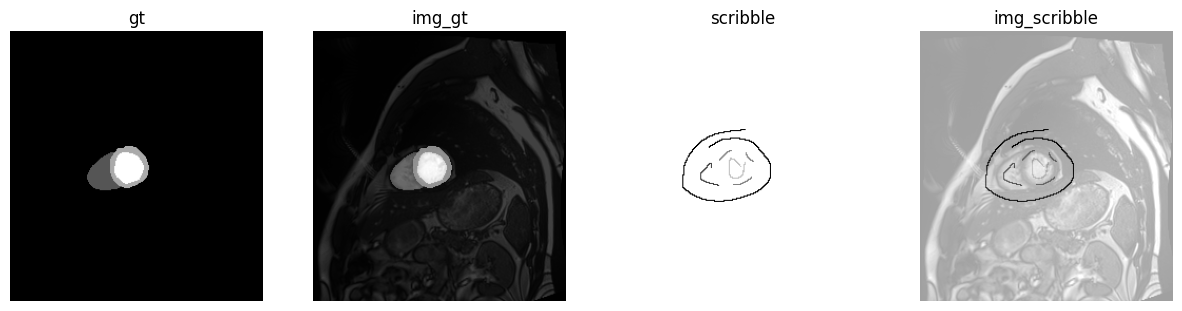

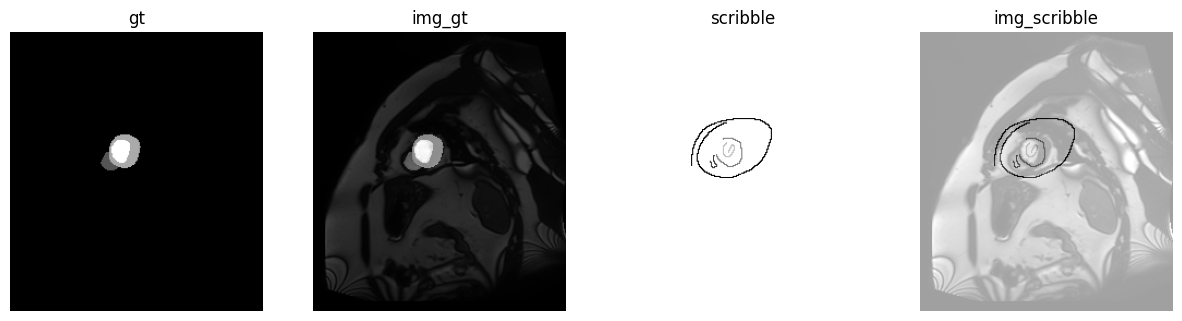

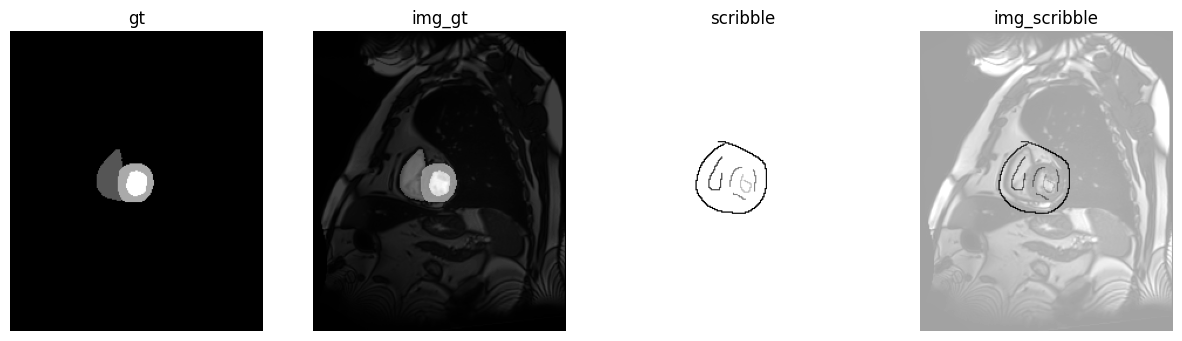

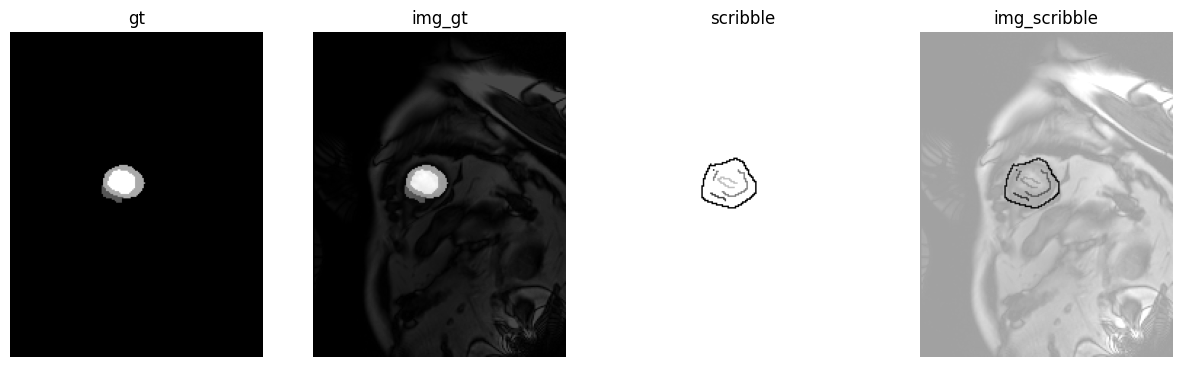

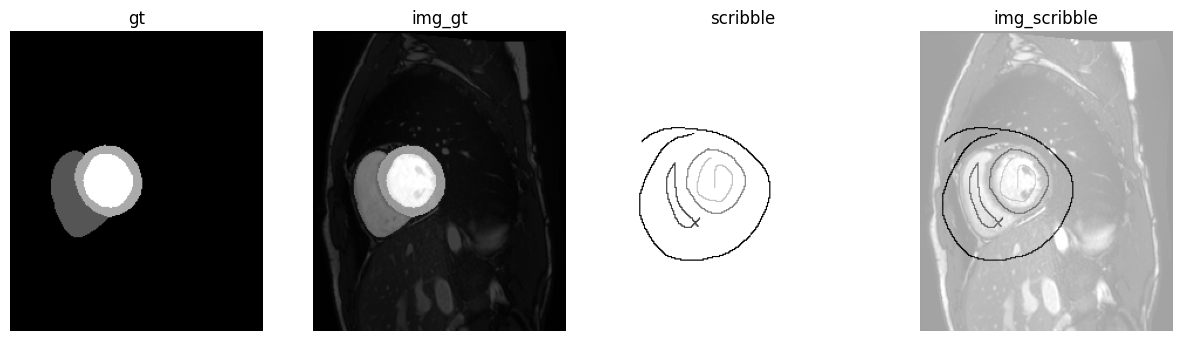

In [ ]:
for i in range(0,10):
    idx = random.randint(0, len(dataset_for_plot))
    plot_all(dataset_for_plot[idx])

In [169]:
%ls

data/  datasets/  train_val_test_split.ipynb


In [170]:
from datasets.ACDC_dataset import BaseDataSets

In [171]:
dataset_for_plot = BaseDataSets(
    base_dir="data/ACDC/",
    split="train",
    num=None,
    transform=None,
)

total 1521 samples


In [175]:
from datasets.utils import plot_all